# Demo

The `mfanalysis` package allows us to perform fractal and multifractal analysis of signals

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set(style="darkgrid")

## Generating a signal

Let's first generate a brownian motion (fractional brownian motion with H=0.5)

In [5]:
from mfanalysis.generate_data import generate_fbm_path

In [6]:
X = generate_fbm_path(5000, 0.5)[:, 0]

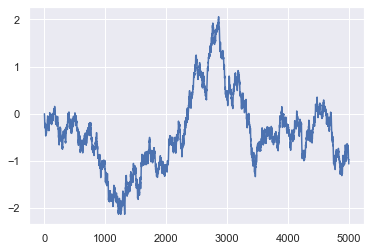

In [7]:
plt.plot(X)
plt.show()

## Second order analysis

Second order analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

In [8]:
import mfanalysis.psd as psd

In [9]:
fs = 1000

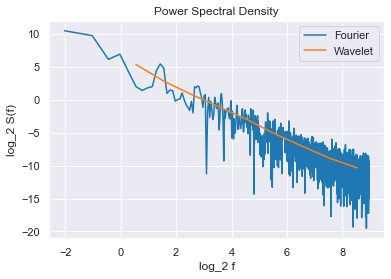

In [10]:
psd.plot_psd(X, fs)

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

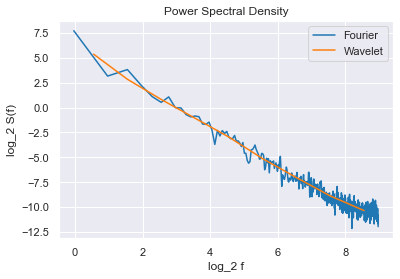

In [11]:
psd.plot_psd(X, fs, n_fft=1024)

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

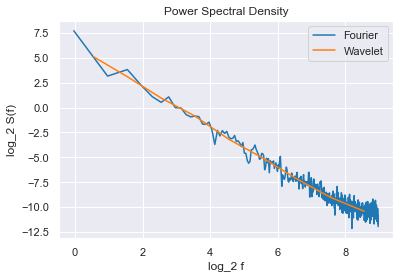

In [12]:
psd.plot_psd(X, fs, n_moments=3, n_fft=1024)

The wavelet-based estimation of the PSD is obtained via the `wavelet_estimation` function

In [13]:
PSD = psd.wavelet_estimation(X, fs, n_moments=3)

The output is an instance of the `PSD` namedtuple, with two fields: `freq` which contains the frequency support of the PSD estimation, and `psd` which contains the actual power estimates

In [14]:
PSD.freq, PSD.psd

(array([375.        , 187.5       ,  93.75      ,  46.875     ,
         23.4375    ,  11.71875   ,   5.859375  ,   2.9296875 ,
          1.46484375]),
 array([7.31677483e-04, 1.93618836e-03, 7.06600673e-03, 2.99810636e-02,
        1.09633393e-01, 5.48944563e-01, 1.93474588e+00, 8.53580993e+00,
        3.43446400e+01]))

## Estimating beta

Our model for the power density spectrum is as follows:

$$ \Gamma(\nu) = C \left| \nu \right| ^ {\beta}$$

Using the log-log plot we can then easily estimate $beta$ by performing a linear regression over the wavelet PSD estimate

In [15]:
import mfanalysis.fractal_analysis as fa

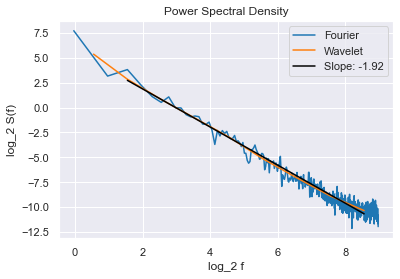

In [16]:
fa.plot_fractal(X, fs, freq_band=(2, 512), n_fft=1024)

The `freq_band` parameter controls the frequency support for the $\beta$ estimation

The `log` parameter allows us to control the log function used, which changes the axes values but not the plotted curves. Available values are contained in the `psd.log_function` dictionary

In [17]:
[*psd.log_function]

['log2', 'log']

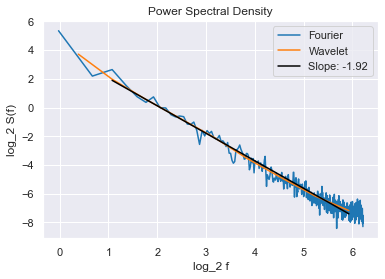

In [18]:
fa.plot_fractal(X, fs, freq_band=(2, 512), n_fft=1024, log='log')

The estimates of $\beta$ and $\log(C)$ can be directly obtained from the signal using the `fractal_analysis` function

In [19]:
fractal = fa.fractal_analysis(X, fs, n_moments=2, freq_band=(2, 512))

The output is an instance of the FractalValues namedtuple, which contains 3 fields:

- `beta`: the estimated 1/f slope
- `log_C`: the logged value of the 1/f intercept
- `freq`: the frequency support for the estimation

In [20]:
fractal

FractalValues(beta=-1.9152047932793343, log_C=5.700364359443716, freq=array([[8.55074679],
       [7.55074679],
       [6.55074679],
       [5.55074679],
       [4.55074679],
       [3.55074679],
       [2.55074679],
       [1.55074679]]))

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet` submodule

In [21]:
from mfanalysis.wavelet import wavelet_analysis

TODO: detail the wavelet transform

In [22]:
WT = wavelet_analysis(X)

/home/dumeur/Multifracs/mfanalysis/mfanalysis/wavelet.py:88: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 9
  f"Max level and j2 set to {max_level}", UserWarning)


The output is a namedtuple with 3 fields:

* `wt_leaders`: The wavelet leaders if computed
* `wt_coefs`: Wavelet coefficients
* `j2_eff`: Maximum scale that the coefficients were effectively computed for

## Multifractal Analysis

Multifractal analysis is done using the `mf_analysis` submodule

In [23]:
import mfanalysis.mf_analysis as mf

In [24]:
import numpy as np

Basic parameters are:

`j1` and `j2`, which indicate respectively the minimum and the maximum scale to consider when fitting wavelet coefficients

`q` The values of q for which the wavelet coefficients will be estimated

`n_cumul` The maximum order of the cumulants to compute

In [25]:
sf, cumul, mfs = mf.mf_analysis_full(X,
    j1=10, j2=14,
    q=np.arange(-2,3),
    n_cumul=2,
)

In [26]:
sf

In [27]:
cumul

In [28]:
mfs

## Object oriented approach

The `Signal` dataclass offers an approach where the signal data and any intermediary results and parameters are kept in an instance

In [29]:
import mfanalysis.signal as sig

In [30]:
S = sig.Signal(X, fs, 'log')

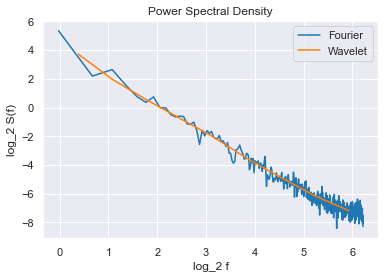

In [31]:
S.plot_psd(n_fft=1024)

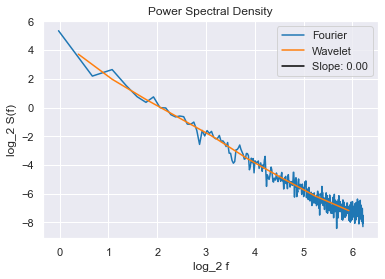

In [32]:
S.plot_fractal(n_fft=1024)

In [33]:
S.fractal_analysis()

FractalValues(beta=0.0, log_C=3.717219596874091, freq=array([[0.38174858]]))

In [34]:
S.wt_psd

PSD(freq=array([375.        , 187.5       ,  93.75      ,  46.875     ,
        23.4375    ,  11.71875   ,   5.859375  ,   2.9296875 ,
         1.46484375]), psd=array([7.65908032e-04, 2.12481693e-03, 7.60005731e-03, 2.84949090e-02,
       1.28112229e-01, 4.76165844e-01, 1.75567346e+00, 7.17048901e+00,
       4.11498218e+01]))

In [ ]:
S.welch_psd

In [36]:
S.fractal

FractalValues(beta=0.0, log_C=3.717219596874091, freq=array([[0.38174858]]))